# Momentum with Rate of Change (ROC) strategy research
По мотивам лекций 1-3 курса `Advanced Algorithmic Futures Trading with Limex`

## Предисловие
Автор долго пытался понять и самостоятельно написать функции из ноутбука `a1` ко второй лекции, но что-то пошло не так и он решёл пойти по другому пути разработки стратегии с помощью библеотеки `Zipline` от `Quantopian`. По совету Владислава Самсонова и от `Zipline` автор тоже отказался и пришёл к использованию `Backtrader`. 

Выбор стратегии для исследования обусловлен простотой реализации, так как целью этого исселедования является не разработка мощной торговой тратегии, а демонстрация работы связки `backtrader-pyfolio` и умения автора находить оптимальные параметры для стратегии

Данное исследование можно разделить на 2 части:
1. Краткое введение в библеотеку `Backtrader` и анализ результатов работы стратегии с помощью упомянутой в курсе библиотеки `pyfolio`
2. Оптимизация параметров стратегии

## Часть 1

Для начала установим необходимые зависимости

In [31]:
!pip install pyfolio-reloaded
!pip install backtrader
!pip install yfinance

Далее определим класс стратегии

In [290]:
import backtrader as bt
import datetime

class ROCMomentumStrategy(bt.Strategy):

    # Метод для получения количества лотов для покупки или продажи в каждой сделке,
    # для простоты пока будем рисковать фиксированным процентом
    def getsizing(self, cash):
        # Рассчитываем риск
        risk_amount = cash * 0.02
        stop_loss = 200
        size = int(risk_amount / stop_loss)
        return size
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.roc = bt.indicators.RateOfChange100(self.data.close, period=20)

    def next(self):
        cash = self.broker.get_cash()
        size = self.getsizing(cash)

        if not self.position:
            if self.roc[0] > 0:
                self.log(f'BUY CREATE, {self.data.close[0]:.2f}')
                self.buy(size=size)
        else:
            if self.roc[0] < 0:
                self.log(f'SELL CREATE, {self.data.close[0]:.2f}')
                self.sell(size=self.position.size)

Далее необходимо загрузить данные для исследование

In [293]:
# Код для скачивания данных, после скачивнаия в файле надо удалить первые строчки
# import yfinance as yf
# # Указываем диапазон дат
# start_date = "2019-01-01"
# end_date = "2025-01-01"
# # Загружаем данные Apple (тикер AAPL)
# data = yf.download("AAPL", start=start_date, end=end_date, interval="1d")
# data.to_csv("AAPL_2019_to_2025_daily.csv")

data = bt.feeds.GenericCSVData(
    dataname='/Users/timurgattarov/algotrading/Onboarding Research/AAPL_2019_to_2025_daily.csv',
    dtformat='%Y-%m-%d',      # Формат даты
    timeframe=bt.TimeFrame.Days,  # Таймфрейм данных (дневной)
    fromdate=datetime.datetime(2020, 1, 1),
    # Указываем индексы столбцов
    close=1,
    high=2,
    low=3,
    open=4,
    volume=5,
    openinterest=-1
)

In [295]:
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(ROCMomentumStrategy)
# Выставляем стартовый капитал
cerebro.broker.set_cash(1000000.0)
# Выставляем коммисию
cerebro.broker.setcommission(commission=0.001)
# Понадобится нам позже 
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()

2020-01-31, BUY CREATE, 75.02
2020-02-21, SELL CREATE, 76.05
2020-04-09, BUY CREATE, 65.11
2020-04-13, SELL CREATE, 66.38
2020-04-14, BUY CREATE, 69.74
2020-09-11, SELL CREATE, 109.33
2020-09-14, BUY CREATE, 112.61
2020-09-16, SELL CREATE, 109.46
2020-10-06, BUY CREATE, 110.46
2020-10-07, SELL CREATE, 112.34
2020-10-08, BUY CREATE, 112.23
2020-10-28, SELL CREATE, 108.55
2020-11-05, BUY CREATE, 116.19
2020-11-09, SELL CREATE, 113.74
2020-11-13, BUY CREATE, 116.62
2020-11-23, SELL CREATE, 111.33
2020-11-25, BUY CREATE, 113.46
2021-01-15, SELL CREATE, 124.32
2021-01-20, BUY CREATE, 129.11
2021-01-29, SELL CREATE, 129.04
2021-02-01, BUY CREATE, 131.17
2021-02-18, SELL CREATE, 127.03
2021-03-31, BUY CREATE, 119.62
2021-05-06, SELL CREATE, 127.06
2021-06-09, BUY CREATE, 124.71
2021-08-11, SELL CREATE, 143.30
2021-08-12, BUY CREATE, 146.28
2021-08-20, SELL CREATE, 145.59
2021-08-23, BUY CREATE, 147.08
2021-09-14, SELL CREATE, 145.52
2021-09-16, BUY CREATE, 146.18
2021-09-17, SELL CREATE, 143.

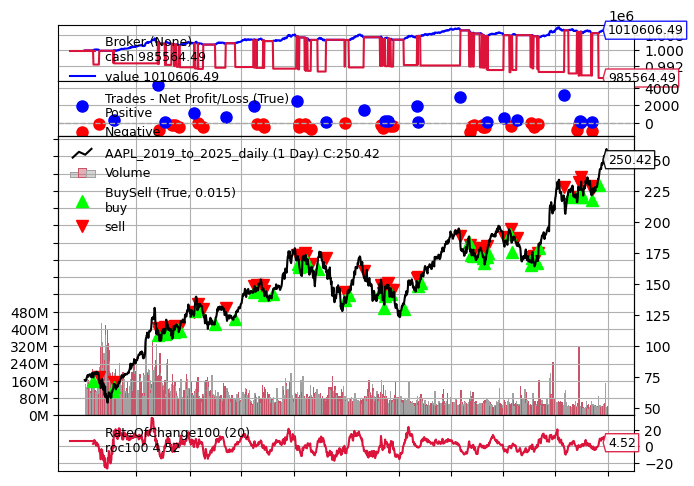

[[<Figure size 640x480 with 5 Axes>]]

In [297]:
''' Построим стандартный график для нашей стратегии (в JupiterNotebook интерактивный графики matplotlib отображаются
не очень хорошо, поэтому стратегии с помощью Backtrader  писать лучще как обычную программу на питоне)'''
%matplotlib inline
cerebro.plot(iplot=False, figsize=(32, 20))

Посмотрим на результаты работы стратегии

In [300]:
print(f"Капитал в конце стратегии : {cerebro.broker.getvalue()}")

Капитал в конце стратегии : 1010606.4890924579


Теперь обработаем нашу стратегию с помощью `pyfolio`

Start date,2020-01-02
End date,2024-12-31
Total months,59
,Backtest
Annual return,0.212%
Cumulative returns,1.061%
Annual volatility,0.304%
Sharpe ratio,0.70
Calmar ratio,0.45
Stability,0.83
Max drawdown,-0.475%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.48,2023-07-31,2024-05-06,2024-07-10,248
1,0.37,2020-09-01,2020-11-27,2021-11-23,321
2,0.33,2022-01-03,2022-02-23,2023-03-31,325
3,0.31,2024-07-16,2024-11-04,NaT,NaN
4,0.09,2021-12-10,2021-12-20,2021-12-27,12


Stress Events,mean,min,max
Covid,0.00%,-0.10%,0.14%


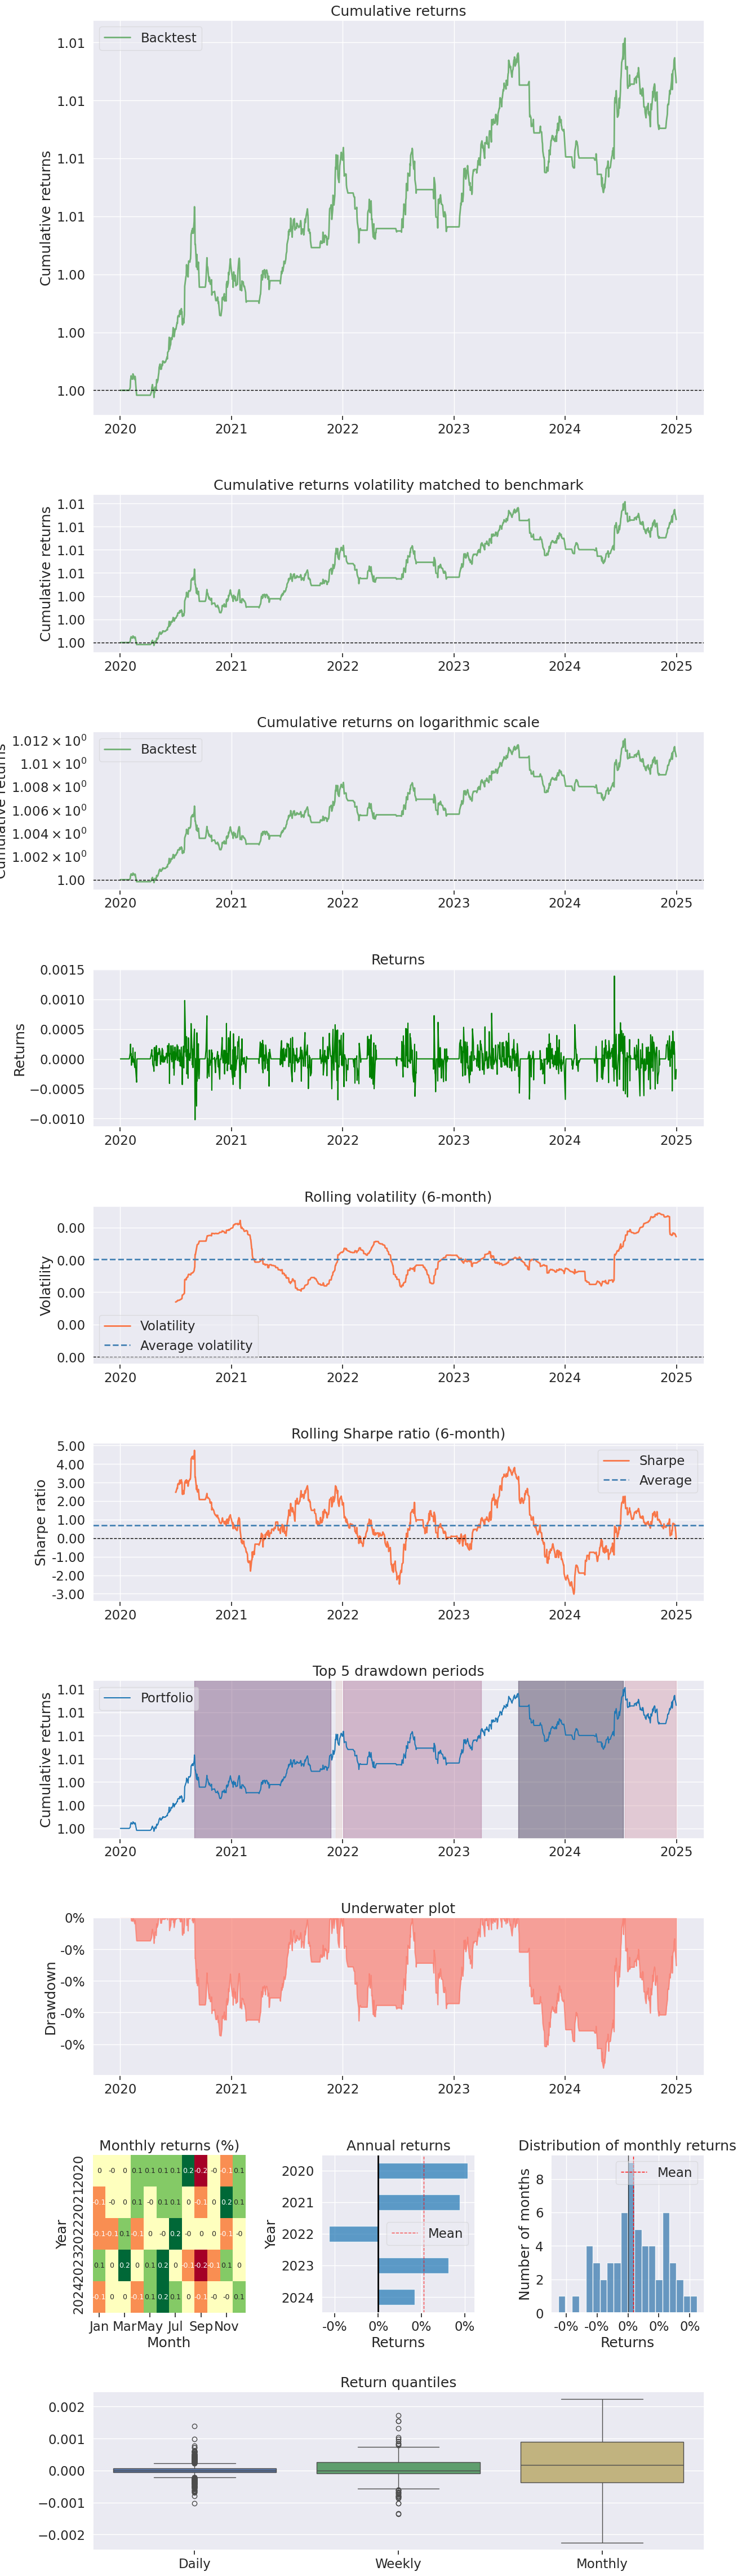

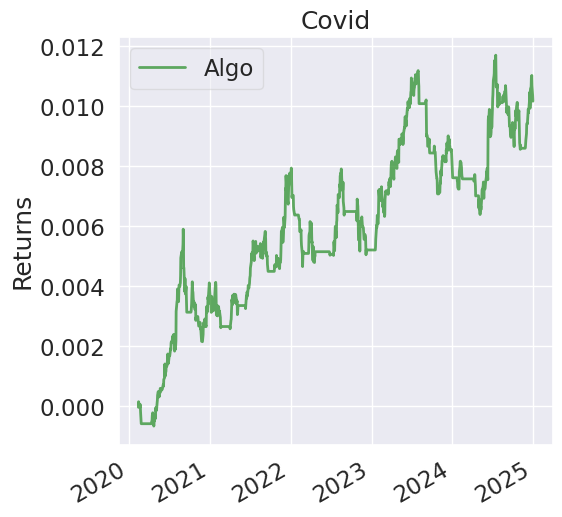

In [303]:
import warnings
warnings.filterwarnings('ignore')
import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt


pyfolio_analyzer = results[0].analyzers.pyfolio
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
returns = pd.Series(returns, index=pd.to_datetime(returns.index))

pf.create_full_tear_sheet(
    returns=returns,
    benchmark_rets=None,
)
plt.show() 

In [309]:
perf_stats = pf.timeseries.perf_stats(returns)
annual_return = perf_stats['Annual return']
cumulative_return = perf_stats['Cumulative returns']
sharpe_ratio = perf_stats['Sharpe ratio']

print(f"Annual Return: {annual_return:.2%}")
print(f"Сumulative Return: {cumulative_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Annual Return: 0.21%
Сumulative Return: 1.06%
Sharpe Ratio: 0.70


Сделаем некоторые выводы: значения годового и итогового дохода кажутся смешными - что на это влияет? 
1. Stop-loss и процент от кэша, которым мы готовы рисковать
2. Период в `RateOfChange100` - вот зависимость от него мы и попробуем происследовать

Коэффициент Шарпа тоже оставляет желать лучшего, постараемся максимально близко подойти к значению 1.0